In [1]:
import os
import math
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Data Exploration
warnings.filterwarnings('ignore')

customer_df = pd.read_excel(r"\Online Retail.xlsx")

In [3]:
# Copy of the orignal data for later use

orig_customer_df = customer_df.copy(deep=True)

#Getting the count of each feature
customer_df.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [4]:
customer_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
#EDA
customer_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot:>

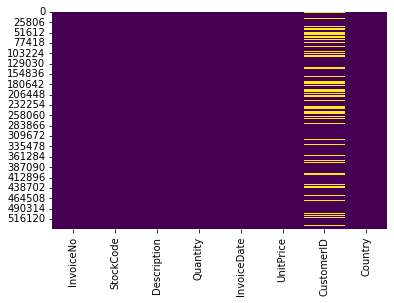

In [6]:
sns.heatmap(customer_df.isnull(),cbar=False,cmap='viridis')

In [7]:
customer_df=customer_df.dropna()

In [8]:
customer_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
customer_df.count()

InvoiceNo      406829
StockCode      406829
Description    406829
Quantity       406829
InvoiceDate    406829
UnitPrice      406829
CustomerID     406829
Country        406829
dtype: int64

In [10]:
# Create Features for RFM
# Take random 15,000 samples for testing
customer_df = customer_df.sample(15000, random_state=42)
customer_df["InvoiceDate"] = customer_df["InvoiceDate"].dt.date
customer_df["TotalSum"] = customer_df["Quantity"] * customer_df["UnitPrice"]
snapshot_date = max(customer_df.InvoiceDate) + datetime.timedelta(days=1)


In [11]:
# aggregate the dataset to compute RFM for each customeer
# Frequency = no. of Invoices/purchases
# Recency  = Last time the customer did the transcation
#Monetary = total have the customer has spend 
agg_customers_df = customer_df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count','TotalSum': 'sum'})
agg_customers_df.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [12]:
agg_customers_df.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,7,163.80
12348.0,249,4,282.64
12349.0,19,2,312.75
12352.0,73,6,100.65
12354.0,233,2,33.30


In [13]:
agg_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3083 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        3083 non-null   int64  
 1   Frequency      3083 non-null   int64  
 2   MonetaryValue  3083 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 96.3 KB


In [14]:
# Check the distribution of RFM values
agg_customers_df.describe()

,Recency,Frequency,MonetaryValue
count,3083.000000,3083.000000,3083.000000
mean,105.850470,4.865391,98.484145
std,102.309306,10.157826,372.962645
min,1.000000,1.000000,-504.000000
25%,25.000000,1.000000,16.500000
50%,65.000000,3.000000,37.080000
75%,172.500000,5.000000,84.530000
max,374.000000,302.000000,11592.040000


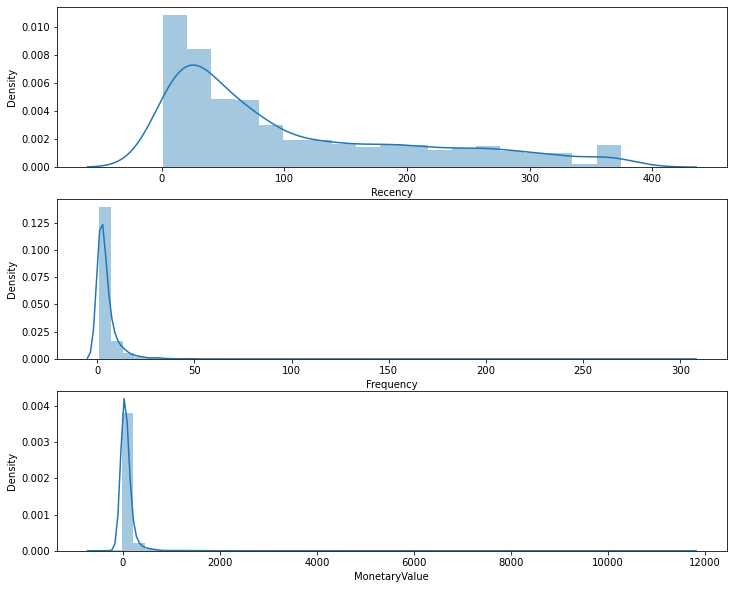

In [15]:
# Plot the squewness of the columns
import matplotlib.pyplot as plt


plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(agg_customers_df['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(agg_customers_df['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(agg_customers_df['MonetaryValue'])
# Show the plot
plt.show()




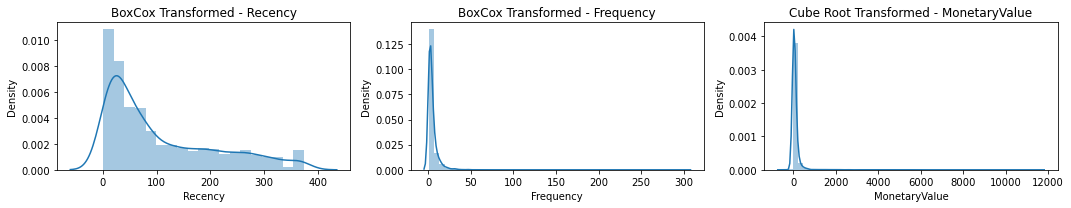

In [16]:
cutomers_bxcxT = agg_customers_df.copy(deep=True)
cutomers_cbrtT = agg_customers_df.copy(deep=True)
nf = [i for i in agg_customers_df.columns]
n=3
plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)-1):
    plt.subplot(1,3,c+1)
    sns.distplot(cutomers_bxcxT[nf[c]])
    plt.title('BoxCox Transformed - {}'.format(nf[c]))
plt.subplot(1,3,3)
sns.distplot(cutomers_cbrtT[nf[2]])
plt.title('Cube Root Transformed - {}'.format(nf[2]))
plt.tight_layout()
plt.show()

In [ ]:
# For the above charts Box plot gives more uniform distribution compared to Square root for R and F columns
# And Cube root for M columns
#

In [17]:
# Create a new data set and apply the transformation
#Applying the selected Transformations

trans_agg_customers_df = pd.DataFrame()
trans_agg_customers_df["Recency"] = stats.boxcox(agg_customers_df['Recency'])[0]
trans_agg_customers_df["Frequency"] = stats.boxcox(agg_customers_df['Frequency'])[0]
trans_agg_customers_df["MonetaryValue"] = pd.Series(np.cbrt(agg_customers_df['MonetaryValue'])).values
trans_agg_customers_df.head()

,Recency,Frequency,MonetaryValue
0,5.734571,1.445647,5.471478
1,10.895216,1.118057,6.562629
2,4.168508,0.621197,6.787853
3,7.205307,1.361222,4.651624
4,10.668493,0.621197,3.217225


In [18]:
#Applying Standardization

scaler = StandardScaler()
scaler.fit(trans_agg_customers_df)
normalize_agg_customers_df = scaler.transform(trans_agg_customers_df)


In [19]:
print(normalize_agg_customers_df.mean(axis = 0).round(2)) 
print(normalize_agg_customers_df.std(axis = 0).round(2)) 

[-0.  0. -0.]
[1. 1. 1.]


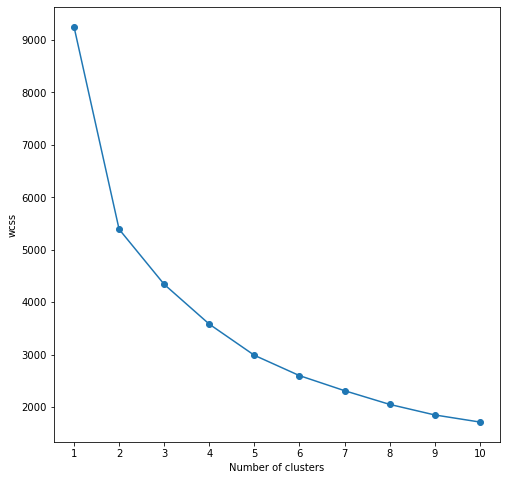

In [21]:
# Find no of clusters using elbow method
list_k = list(range(1, 11))
wcss = []

for k in list_k:
    km = KMeans(n_clusters=k,  max_iter = 300,
                    n_init=10)
    km.fit(normalize_agg_customers_df)
    wcss.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, wcss, '-o')
plt.xticks(list_k, list(range(1,11,1)))
plt.xlabel('Number of clusters')
plt.ylabel('wcss');
plt.show()



In [22]:
# From the above graph we select 3 as no of clusters
#So the idea here is to select a number of clusters after which we don't see much difference in the WCSS, let's go for 3
kmeans = KMeans(n_clusters = 3,
                   max_iter = 300,
                n_init=10,
                random_state = 0)
y_kmeans = kmeans.fit_predict(normalize_agg_customers_df)


In [23]:
print(y_kmeans)
print(kmeans.cluster_centers_) 

[2 2 2 ... 0 2 2]
[[-0.47445657 -0.49541928 -0.48579223]
 [ 1.08690341 -0.59316923 -0.38871421]
 [-0.69520285  1.05295426  0.83389565]]


In [24]:
# Add cluser to data set
agg_customers_df['Cluster'] = y_kmeans
agg_customers_df.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,7,163.80,2
12348.0,249,4,282.64,2
12349.0,19,2,312.75,2
12352.0,73,6,100.65,2
12354.0,233,2,33.30,1


In [25]:
#Analyse the cluster
agg_customers_df.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         44.44      2.07         25.42   945
1        222.69      1.97         35.34  1085
2         40.57     10.36        229.11  1053

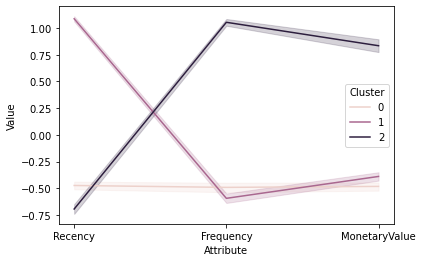

In [27]:
# Visualising the Cluster Chartecteristics

df_normalized = pd.DataFrame(normalize_agg_customers_df, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = agg_customers_df.index
df_normalized['Cluster'] = y_kmeans
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)
plt.show()